In [1]:
from __future__ import print_function, division
import os, sys
os.environ['KERAS_BACKEND'] = "tensorflow"
import keras.backend as K
K.set_image_dim_ordering('tf')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [23]:
from pyqae.dnn.features import PhiComGrid2DLayer
from keras.layers import add, Activation, Lambda
from keras.models import Model
from keras.models import Sequential, Model, Input
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D, BatchNormalization, concatenate, Conv2DTranspose
from keras.optimizers import SGD, Adam, Adadelta
from pyqae.dnn.loss import wdice_coef, show_loss
DEFAULT_OPT = Adam(lr=1e-2) 
DEFAULT_OPT = Adam(lr=4e-3)
DEFAULT_OPT = Adam(lr=1e-3)
DEFAULT_OPT = Adadelta() # parameter-free
def compile_model(i_model, optimizer = DEFAULT_OPT):
    i_model.compile(optimizer = DEFAULT_OPT, 
                    loss = 'binary_crossentropy',
                    metrics = ['mse', wdice_coef(1.0), 'binary_crossentropy'])

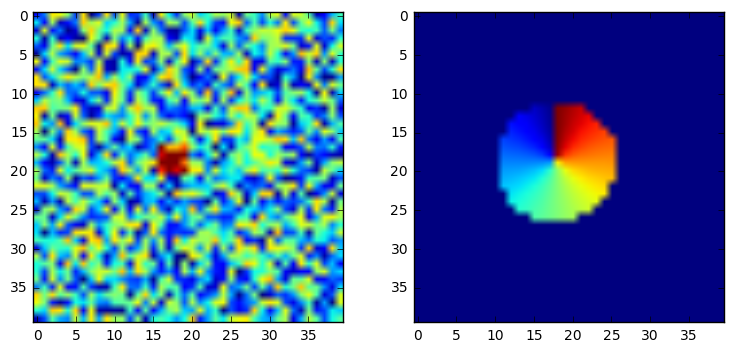

In [3]:
lin_x = np.linspace(-1, 1, 40)
lin_y = np.linspace(-1, 1, 40)
xx, yy = np.meshgrid(lin_x, lin_y, indexing = 'ij')
def get_single_image():
    x_c, y_c = np.random.uniform(-0.5,0.5, size = 2)
    n_xx, n_yy = xx-x_c, yy-y_c
    base_img = ((np.abs(n_xx)<0.1)*(np.abs(n_yy)<0.1)).astype(np.float32)
    base_img += np.random.uniform(-0.5, 0.5, size = base_img.shape)
    base_img *= np.random.normal(1, 0.2)
    base_img = base_img.clip(-1,1)
    mask_img = (np.sqrt(np.square(n_xx)+np.square(n_yy))<0.4)*(1+np.arctan2(n_yy, n_xx)/np.pi)/2
    mask_img = mask_img.clip(0,1)
    return base_img, mask_img
def get_image_gen(batch_size = 1):
    while True:
        t_list, m_list = [], []
        for _ in range(batch_size):
            t_img, m_img = get_single_image() 
            t_list += [t_img]
            m_list += [m_img]
        p_fun = lambda x: np.expand_dims(np.stack(x,0),-1)
        yield p_fun(t_list), p_fun(m_list)

t_img, m_img = get_single_image()
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (9, 4))
ax1.imshow(t_img)
ax2.imshow(m_img)

In [24]:
def show_model(in_model, steps):
    fig, (m_axs) = plt.subplots(steps, 3, figsize = (9, 3*steps))
    for (ax1, ax2, ax3), (c_img, c_view) in zip(m_axs, get_image_gen(1)):
        ax1.imshow(c_img[0, :, :, 0])
        ax2.imshow(c_view[0, :, :, 0], vmin = 0, vmax = 1)
        ax2.set_title('GT')
        ax3.imshow(in_model.predict(c_img)[0, :, :, 0], vmin = 0, vmax = 1)
        ax3.set_title('Prediction')
def fit_model(in_model):
    return [in_model.fit_generator(get_image_gen(16), 
                                             steps_per_epoch=200, epochs=3, 
                                   validation_data=get_image_gen(32), 
                                   validation_steps=1)]
def simple_cnn(input_shape, layers, 
               depth, 
               out_filters = None, 
               out_activation = 'sigmoid',
              def_args = dict(kernel_size = (3,3), 
                             padding = 'same', activation = 'relu')):
    out_model = Sequential()
    out_model.add(Convolution2D(input_shape = input_shape, filters = depth, **def_args))
    for i in range(layers-1):
        out_model.add(Convolution2D(filters = depth, **def_args))
    out_model.add(Convolution2D(filters = out_filters if out_filters is not None else depth,
                                kernel_size = (1,1),
                               activation = out_activation))
    compile_model(out_model)
    return out_model

In [59]:
i_shape = (None, None, 1)
basic_model = simple_cnn(i_shape, 8, 32, 
                         out_filters = 1)
basic_model_lh = []
basic_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_112 (Conv2D)          (None, None, None, 32)    320       
_________________________________________________________________
conv2d_113 (Conv2D)          (None, None, None, 32)    9248      
_________________________________________________________________
conv2d_114 (Conv2D)          (None, None, None, 32)    9248      
_________________________________________________________________
conv2d_115 (Conv2D)          (None, None, None, 32)    9248      
_________________________________________________________________
conv2d_116 (Conv2D)          (None, None, None, 32)    9248      
_________________________________________________________________
conv2d_117 (Conv2D)          (None, None, None, 32)    9248      
_________________________________________________________________
conv2d_118 (Conv2D)          (None, None, None, 32)    9248      
__________

In [60]:
basic_model_lh += fit_model(basic_model)

C:\IntelPython35\envs\tf-xg-boost\lib\site-packages\keras\backend\tensorflow_backend.py:2289: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Epoch 1/3
200/200 [==============================] - 17s - loss: 0.2050 - mean_squared_error: 0.0353 - cdice_score: 0.0063 - binary_crossentropy: 0.2050 - val_loss: 0.0989 - val_mean_squared_error: 0.0079 - val_cdice_score: 0.0050 - val_binary_crossentropy: 0.0989
Epoch 2/3
200/200 [==============================] - 15s - loss: 0.0818 - mean_squared_error: 0.0051 - cdice_score: 0.0111 - binary_crossentropy: 0.0818 - val_loss: 0.0724 - val_mean_squared_error: 0.0034 - val_cdice_score: 0.0057 - val_binary_crossentropy: 0.0724
Epoch 3/3
200/200 [==============================] - 15s - loss: 0.0717 - mean_squared_error: 0.0033 - cdice_score: 0.0115 - binary_crossentropy: 0.0717 - val_loss: 0.0700 - val_mean_squared_error: 0.0030 - val_cdice_score: 0.0052 - val_binary_crossentropy: 0.0700


C:\IntelPython35\envs\tf-xg-boost\lib\site-packages\keras\backend\tensorflow_backend.py:2289: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


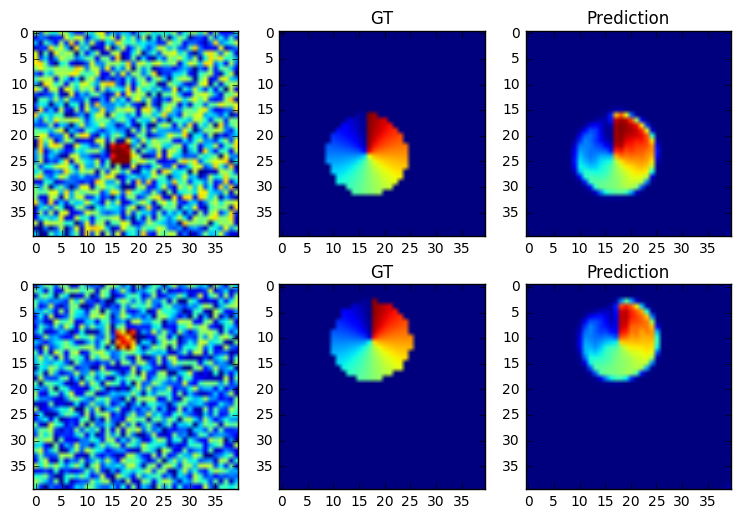

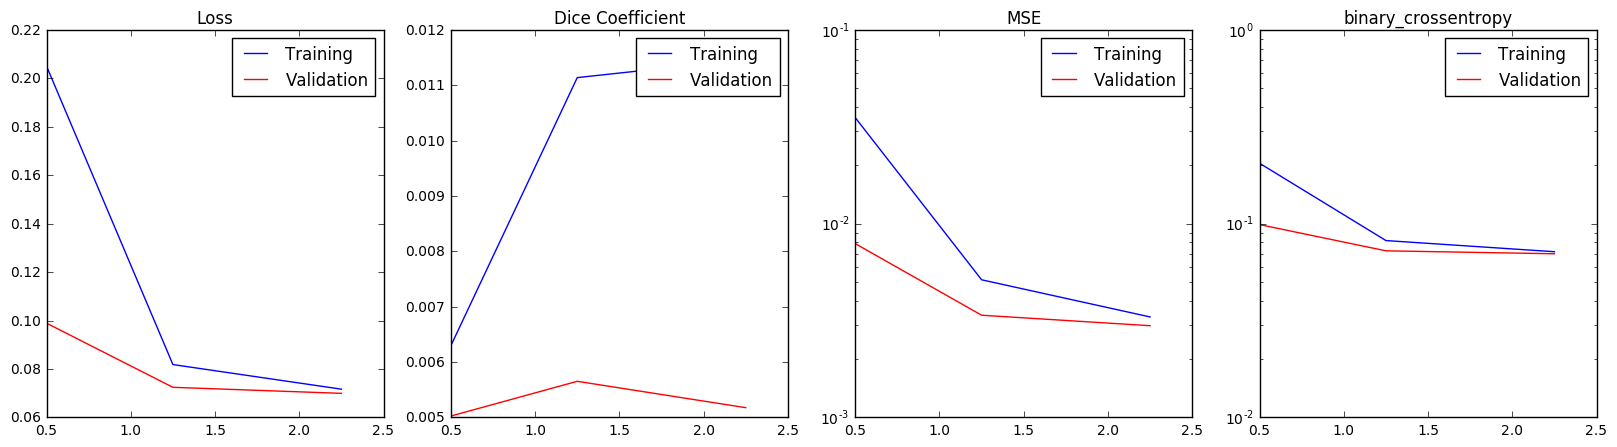

In [61]:
show_model(basic_model, 2)
show_loss(basic_model_lh)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_126 (Conv2D)          (None, None, None, 48)    480       
_________________________________________________________________
conv2d_127 (Conv2D)          (None, None, None, 48)    20784     
_________________________________________________________________
conv2d_128 (Conv2D)          (None, None, None, 48)    20784     
_________________________________________________________________
conv2d_129 (Conv2D)          (None, None, None, 48)    20784     
_________________________________________________________________
conv2d_130 (Conv2D)          (None, None, None, 48)    20784     
_________________________________________________________________
conv2d_131 (Conv2D)          (None, None, None, 48)    20784     
_________________________________________________________________
conv2d_132 (Conv2D)          (None, None, None, 48)    20784     
__________

C:\IntelPython35\envs\tf-xg-boost\lib\site-packages\keras\backend\tensorflow_backend.py:2289: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Epoch 1/3
200/200 [==============================] - 47s - loss: 0.1601 - mean_squared_error: 0.0262 - cdice_score: 0.0085 - binary_crossentropy: 0.1601 - val_loss: 0.0749 - val_mean_squared_error: 0.0048 - val_cdice_score: 0.0048 - val_binary_crossentropy: 0.0749
Epoch 2/3
200/200 [==============================] - 45s - loss: 0.0733 - mean_squared_error: 0.0038 - cdice_score: 0.0113 - binary_crossentropy: 0.0733 - val_loss: 0.0710 - val_mean_squared_error: 0.0031 - val_cdice_score: 0.0060 - val_binary_crossentropy: 0.0710
Epoch 3/3
200/200 [==============================] - 43s - loss: 0.0703 - mean_squared_error: 0.0031 - cdice_score: 0.0115 - binary_crossentropy: 0.0703 - val_loss: 0.0693 - val_mean_squared_error: 0.0027 - val_cdice_score: 0.0055 - val_binary_crossentropy: 0.0693


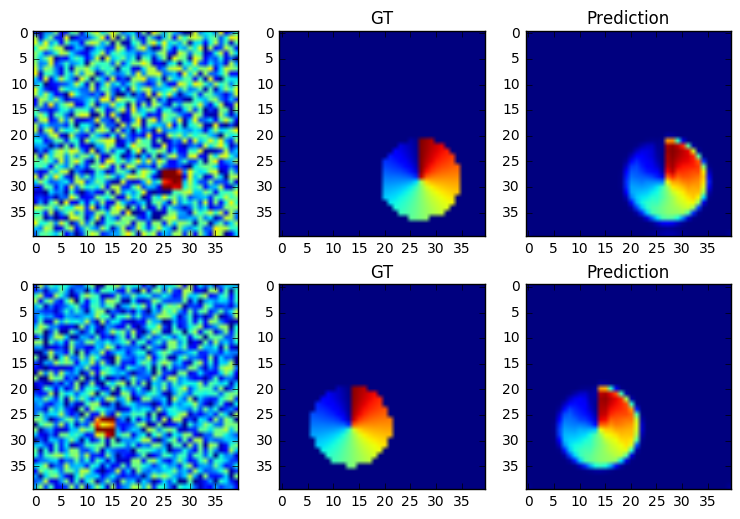

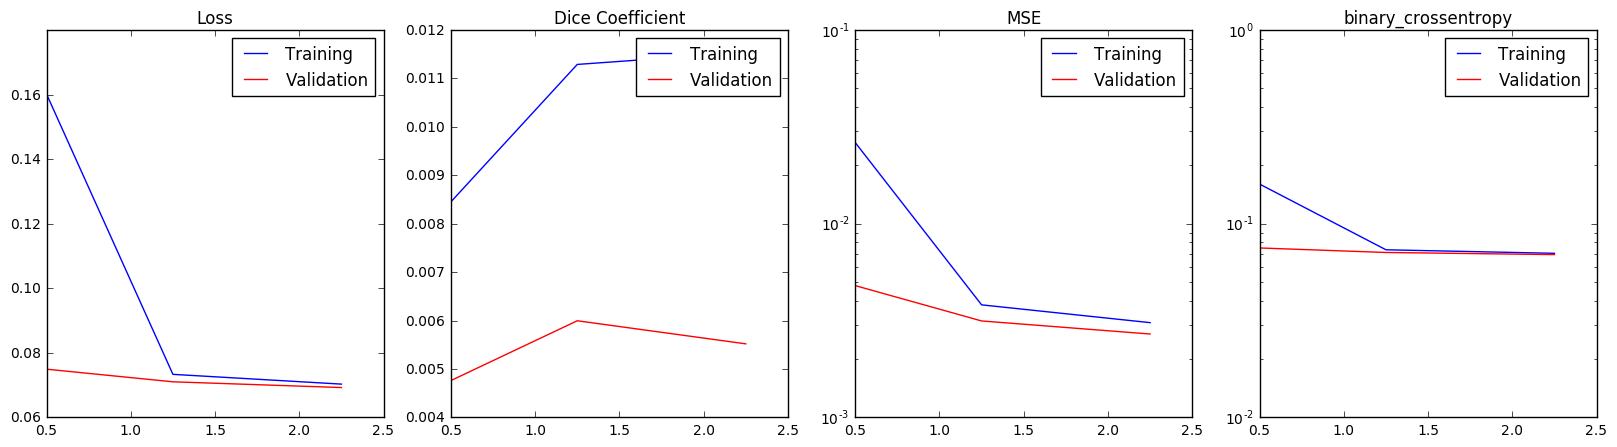

In [68]:
i_shape = (None, None, 1)
deep_model = simple_cnn(i_shape, 16, 48, 
                         out_filters = 1)
deep_model_lh = []
deep_model.summary()
deep_model_lh += fit_model(deep_model)
show_model(deep_model, 2)
show_loss(deep_model_lh)

In [30]:
pl_input = Input(shape = (None, None, None))
pl_layer = PhiComGrid2DLayer(z_rad = 0, include_r = True, include_ir=False, name = 'PhiLayer')
pl_values = pl_layer(pl_input)
phi_layer_model = Model(inputs = [pl_input], outputs = [concatenate([pl_input, pl_values])], name = 'PhiCatModel')
phi_model = Sequential()
phi_model.add(simple_cnn(i_shape, 8, 8, out_filters = 1))
phi_model.add(phi_layer_model)
phi_model.add(simple_cnn((None, None, 4), 8, 8, out_filters = 1))
compile_model(phi_model)
phi_model_lh = []
phi_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_11 (Sequential)   (None, None, None, 1)     4177      
_________________________________________________________________
PhiCatModel (Model)          multiple                  0         
_________________________________________________________________
sequential_12 (Sequential)   (None, None, None, 1)     4393      
Total params: 8,570
Trainable params: 8,570
Non-trainable params: 0
_________________________________________________________________


In [33]:
phi_model_lh += fit_model(phi_model)

Epoch 1/3
200/200 [==============================] - 20s - loss: 0.1781 - mean_squared_error: 0.0307 - cdice_score: 0.0098 - binary_crossentropy: 0.1781 - val_loss: 0.1721 - val_mean_squared_error: 0.0297 - val_cdice_score: 0.0053 - val_binary_crossentropy: 0.1721
Epoch 2/3
200/200 [==============================] - 18s - loss: 0.2255 - mean_squared_error: 0.0389 - cdice_score: 0.0056 - binary_crossentropy: 0.2255 - val_loss: 0.2198 - val_mean_squared_error: 0.0359 - val_cdice_score: 0.0023 - val_binary_crossentropy: 0.2198
Epoch 3/3
200/200 [==============================] - 17s - loss: 0.2091 - mean_squared_error: 0.0349 - cdice_score: 0.0051 - binary_crossentropy: 0.2091 - val_loss: 0.2005 - val_mean_squared_error: 0.0339 - val_cdice_score: 0.0028 - val_binary_crossentropy: 0.2005


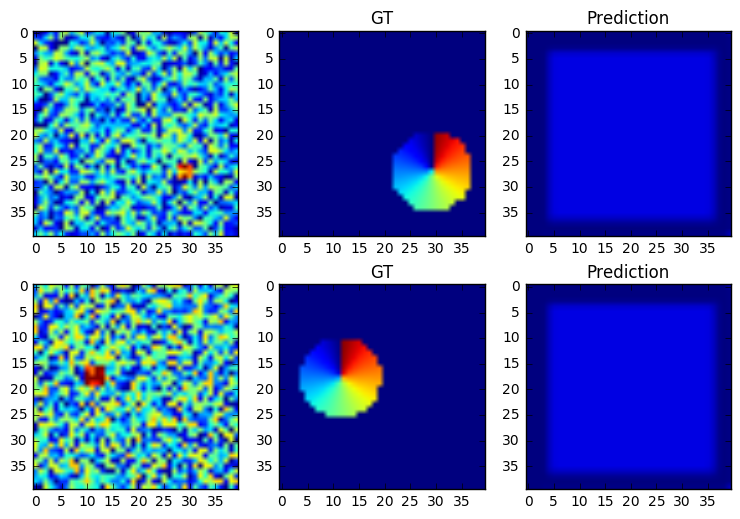

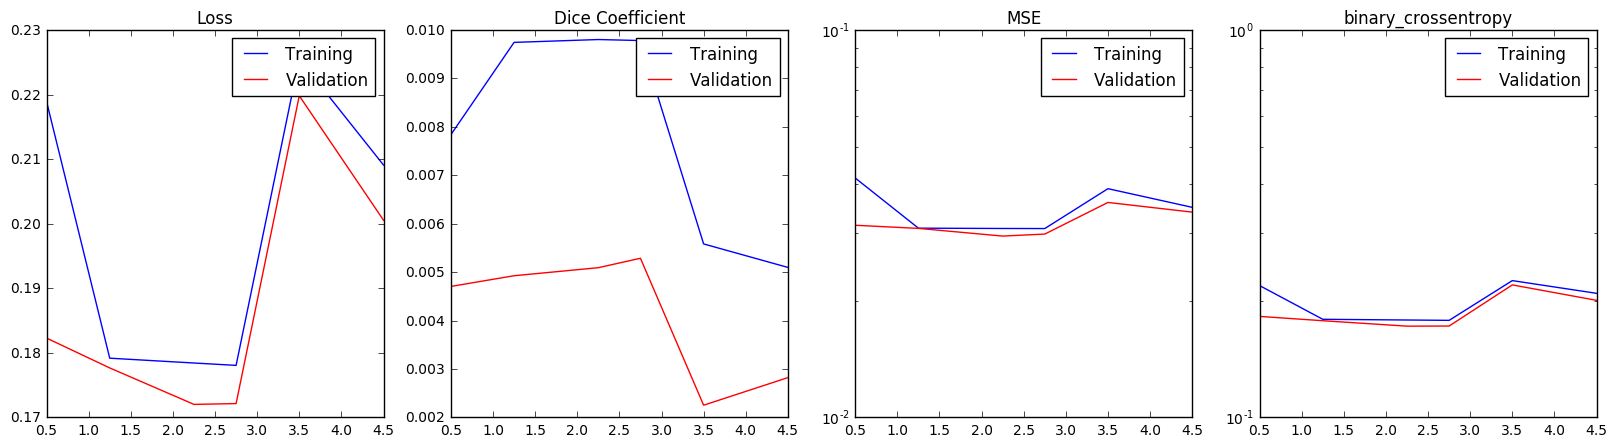

In [34]:
show_model(phi_model, 2)
show_loss(phi_model_lh)

In [62]:
phi_pt_model = Sequential()
basic_model.trainable = False
for i_lay in basic_model.layers:
    i_lay.trainable = False
phi_pt_model.add(basic_model)
phi_pt_model.add(phi_layer_model)
#phi_pt_model.add(pl_layer)
phi_pt_model.add(simple_cnn((None, None, 4), 4, 32, out_filters = 1))

print(phi_pt_model.layers[1])
compile_model(phi_pt_model)
phi_pt_model_lh = []
phi_pt_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_29 (Sequential)   (None, None, None, 1)     65089     
_________________________________________________________________
PhiCatModel (Model)          multiple                  0         
_________________________________________________________________
sequential_31 (Sequential)   (None, None, None, 1)     28961     
Total params: 94,050
Trainable params: 28,961
Non-trainable params: 65,089
_________________________________________________________________


In [66]:
phi_pt_model_lh += fit_model(phi_pt_model)

Epoch 1/3
200/200 [==============================] - 12s - loss: 0.0697 - mean_squared_error: 0.0029 - cdice_score: 0.0115 - binary_crossentropy: 0.0697 - val_loss: 0.0681 - val_mean_squared_error: 0.0024 - val_cdice_score: 0.0052 - val_binary_crossentropy: 0.0681
Epoch 2/3
200/200 [==============================] - 12s - loss: 0.0691 - mean_squared_error: 0.0028 - cdice_score: 0.0115 - binary_crossentropy: 0.0691 - val_loss: 0.0690 - val_mean_squared_error: 0.0028 - val_cdice_score: 0.0051 - val_binary_crossentropy: 0.0690
Epoch 3/3
200/200 [==============================] - 12s - loss: 0.0689 - mean_squared_error: 0.0027 - cdice_score: 0.0116 - binary_crossentropy: 0.0689 - val_loss: 0.0681 - val_mean_squared_error: 0.0026 - val_cdice_score: 0.0055 - val_binary_crossentropy: 0.0681


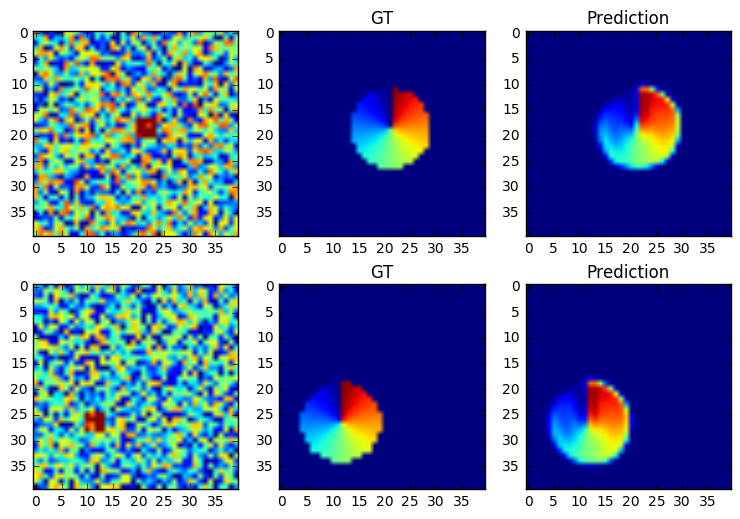

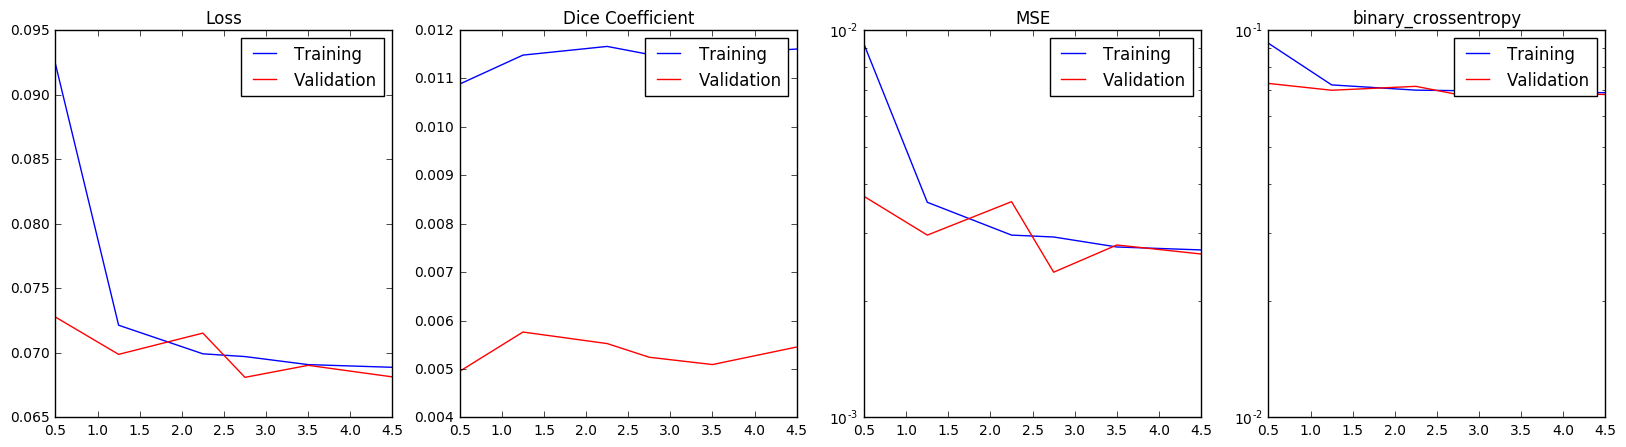

In [67]:
show_model(phi_pt_model, 2)
show_loss(phi_pt_model_lh)